# Lab 03: Pitch Classification

---
author: Alejandra Arias
date: September 20, 2024
embed-resources: true
---

## Introduction

In this report, we develop a machine learning model to classify the type of pitch thrown by a baseball pitcher. The dataset used in this report is the "Pitch Type Data" dataset from the [Statcast](https://baseballsavant.mlb.com/about) database. The dataset contains information about the pitch velocity, pitch movement, and pitch location for each pitch thrown by a pitcher in the 2018 Major League Baseball (MLB) season. The goal of this report is to develop a pipeline and KNN Classifier that can predict the type of pitch thrown by a pitcher based on the input features provided in the dataset.

### Background
A pitch type is defined by what the pitcher claims they threw, and it is classified into one of the following categories: fastball, changeup, curveball, slider, cutter, sinker, and knuckleball. The pitch type is determined by the pitcher's grip, arm angle, and the movement of the pitch. For some extre context, television broadcasrs use machine learning to instantly display the pitch typeby:
- having advanced tracking technology that captures the pitch's velocity, movement, and location in real-time.
- have a trained classifier for pitch type based on speed, spin, and more
- display the pitch type on the screen for viewers to see.
For this report, we will be looking ath the pitches for a single pitcher, [Shohei Ohtani](https://www.baseball-reference.com/players/o/ohtansh01.shtml), who is known for his ability to throw a variety of pitches at different speeds and movements.

### Goal
The goal of this report is to create a classification model that predicts the type of pitch thrown by a particular pitcher given the pitch's velocity, movement, and location. We will use the K-Nearest Neighbors (KNN) algorithm to classify the pitch type based on the input features provided in the dataset. We will evaluate the model's performance using the accuracy score.

## Methods

In [65]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

### Data

In [66]:
# load data
pitches_train = pd.read_parquet(
    "https://cs307.org/lab-03/data/pitches-train.parquet"
)
pitches_test = pd.read_parquet(
    "https://cs307.org/lab-03/data/pitches-test.parquet"
)
pitches_train

,pitch_name,release_speed,release_spin_rate,pfx_x,pfx_z,stand
0,Sweeper,84.7,2667.0,1.25,0.01,R
1,Sweeper,83.9,2634.0,1.41,0.20,R
2,Sweeper,84.4,2526.0,1.26,0.25,R
3,Curveball,74.3,2389.0,0.93,-1.10,L
4,Sweeper,85.6,2474.0,1.08,0.52,R
...,...,...,...,...,...,...
2623,Split-Finger,91.8,1314.0,-0.30,0.08,R
2624,Sweeper,86.9,2440.0,1.11,0.51,R
2625,4-Seam Fastball,99.2,2320.0,0.04,0.81,R
2626,4-Seam Fastball,97.9,2164.0,0.08,1.06,R


### Source
The original source of the data is [Statcast](https://en.m.wikipedia.org/wiki/Statcast), a database that collects detailed information about every pitch thrown in the MLB. Specifically, the [pybaseball](https://pypi.org/project/pybaseball/) library was used to extract the data for Shohei Ohtani from the 2018 MLB season.

## Data Dictionary

Each observation in the train, test, and production data contains information about a single pitch thrown by Shohei Ohtani in either 2022 which is the train data, 2023 which is the test data, or 2024 which is the production data. 

Here, the train-test split is based on time:
- Train: 2022 MLB season
- Test: (girst half of) 2023 MLB season

This original documentation for statcast data can be found [here](https://baseballsavant.mlb.com/csv-docs).

The data contains the following columns:

### Response
**`pitch_name`**

- `[object]` the name of the pitch, which is the name of the pitch type thrown

### Features
**`release_spin_rate`**

- `[float64]` pitch spin rate (revolutions per minute) measured shortly after leaving the pitcher's hand
    
**`pfx_x`**

- `[float64]` horiznotal movement (feet) of the pitch from the catcher's perspective

**`pfx_z`**

- `[float64]` vertical movement (feet) of the pitch from the catcher's perspective

**`stand`**

- `[object]` side of the plate batter is standing, either `L` (left) or `R` (right)
    


In [67]:
# summary statistics
samples = pitches_train.shape[0]
features = pitches_train.shape[1]
samples, features

(2628, 6)

In [68]:
pitches_train['pitch_name'].agg(["value_counts", lambda x: x.value_counts(normalize=True)]).rename(columns={"value_counts": "count", "<lambda>": "proportion"})

,count,proportion
pitch_name,,
Sweeper,983,0.374049
4-Seam Fastball,718,0.273212
Split-Finger,312,0.118721
Cutter,233,0.088661
Curveball,222,0.084475
Sinker,97,0.036910
Slider,63,0.023973


In [69]:
pitches_train[['pitch_name', 'release_speed']].groupby('pitch_name').agg(['mean', 'std'])

release_speed          
                         mean       std
pitch_name                             
4-Seam Fastball     97.270613  1.699270
Curveball           77.679730  3.215206
Cutter              90.742060  2.364489
Sinker              97.160825  1.829592
Slider              85.203175  2.401543
Split-Finger        89.291346  1.759299
Sweeper             85.336419  1.862552

In [70]:
pitches_train[['pitch_name', 'release_spin_rate']].groupby('pitch_name').agg(['mean', 'std'])

release_spin_rate            
                             mean         std
pitch_name                                   
4-Seam Fastball       2217.331933  114.754683
Curveball             2482.666667  119.854726
Cutter                2378.424893  206.685887
Sinker                1972.747368  143.920632
Slider                2497.619048   78.679306
Split-Finger          1273.560897  221.291146
Sweeper               2492.172940  103.176892

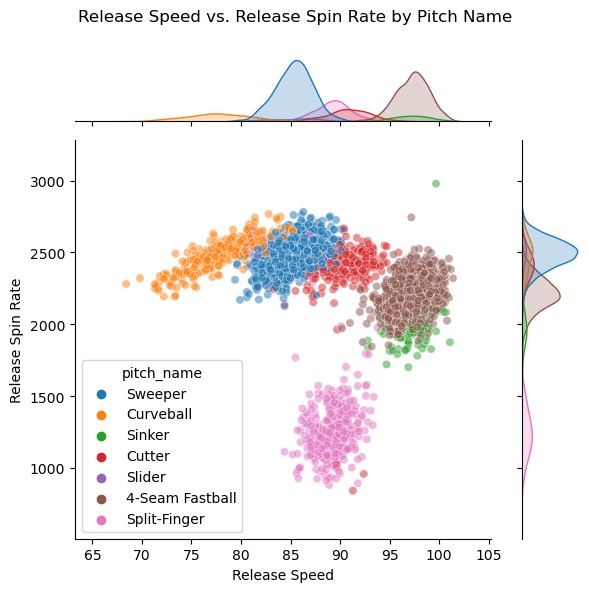

In [71]:
# visualizations
plot = sns.jointplot(data=pitches_train, x='release_speed', y='release_spin_rate', hue='pitch_name', alpha=0.5)

plot.set_axis_labels('Release Speed', 'Release Spin Rate')
plot.fig.suptitle('Release Speed vs. Release Spin Rate by Pitch Name')
plot.fig.tight_layout()


plot.fig.subplots_adjust(top=0.9)
plt.show()

The jointplot below shows the relationship between the `release_spin_rate` and `release_speed` features in the dataset with the `pitch_names` response. There appears to be a linear relationship between the `release_spin_rate` and `release_speed` features for each pitch type. Although with `Split-Finger` not scattered with the rest we can still see some linear relationship between the two features.

### Models

In [72]:
# process data for ML
# create X and y for train
X_train = pitches_train.drop("pitch_name", axis=1)
y_train = pitches_train["pitch_name"]

# create X and y for test
X_test = pitches_test.drop("pitch_name", axis=1)
y_test = pitches_test["pitch_name"]

In [73]:
# check shapes of data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2628, 5), (2628,), (1620, 5), (1620,))

In [74]:
pitches_train["stand"]

0       R
1       R
2       R
3       L
4       R
       ..
2623    R
2624    R
2625    R
2626    R
2627    R
Name: stand, Length: 2628, dtype: object

In [75]:
# note numeric and categorical features
numeric_features = ["release_speed", "release_spin_rate", "pfx_x", "pfx_z"]
categorical_features = ["stand"]

In [76]:
pitches_train.dtypes

pitch_name            object
release_speed        float64
release_spin_rate    float64
pfx_x                float64
pfx_z                float64
stand                 object
dtype: object

In [77]:
# define preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
        ,
    ]
)

# define preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, ["stand"]),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier()),
    ]
)

In [78]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['release_speed',
                                                   'release_spin_rate', 'pfx_x',
                                                   'pfx_z']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['stand'])])),
                ('classifier', KNeighborsClassifier())])

In [79]:
param_grid = {
    "preprocessor__cat__onehot__drop": [None, "first"],
    "preprocessor__num__scaler": [None, StandardScaler()],
    "classifier__n_neighbors": [3, 5, 7, 9, 11],
    "classifier__metric": ["euclidean", "manhattan"],
}

In [80]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy")
mod = grid_search.fit(X_train, y_train)

In [81]:
mod.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['release_speed',
                                                                          'release_spin_rate',
                                                                          'pfx_x',
                                                                          'pfx_z']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['stand'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__metric': ['euclidean', 'manhattan'],
                         'classifier__n_neighbors': [3, 5, 7, 9, 11],
                         'preprocessor__cat__onehot__drop': [None, 'first'],
                         'preprocessor__num__scaler': [None, StandardScaler()]},
             scoring='accuracy')

In [82]:
print(f"Best parameters: {mod.best_params_}")
print(f"Best cross-validation accuracy: {mod.best_score_}")

Best parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'preprocessor__cat__onehot__drop': None, 'preprocessor__num__scaler': StandardScaler()}
Best cross-validation accuracy: 0.9760195545898969


In [83]:
y_pred = grid_search.predict(X_test)

In [84]:
from joblib import dump
dump(mod, "pitch-classifier.joblib")

['pitch-classifier.joblib']

To develop the classification model, we will use the K-Nearest Neighbors (KNN) algorithm. The KNN algorithm is a simple and effective algorithm for classification tasks. It classifies a new data point based on the majority class of its K-nearest neighbors. The algorithm is non-parametric, meaning it does not make any assumptions about the underlying data distribution. The hyperparameter K is the number of neighbors used to classify a new data point. We will also use a pipeline to preprocess the data and train the KNN classifier.

## Results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


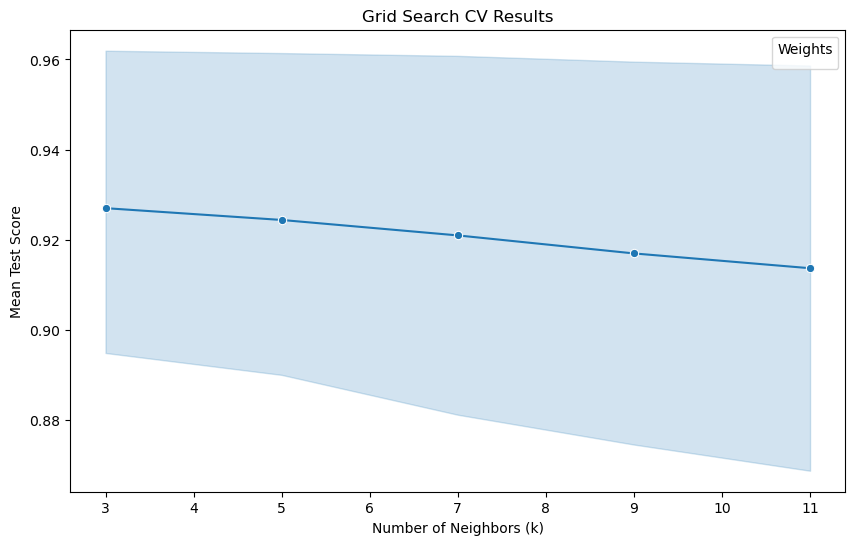

In [85]:
# report model metrics
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df = cv_results_df[
    [
        "param_preprocessor__cat__onehot__drop",
        "param_classifier__n_neighbors",
        "param_classifier__metric",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
]
plt.figure(figsize=(10, 6))
sns.lineplot(data=cv_results_df, x='param_classifier__n_neighbors', y='mean_test_score', marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Test Score')
plt.title('Grid Search CV Results')
plt.legend(title='Weights')
plt.show()

In [86]:
print(f"Test set accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test Error: {1 - accuracy_score(y_test, y_pred)}")

Test set accuracy: 0.9358024691358025
Test Error: 0.06419753086419755


Our model had a test accuracy score of ~0.9358 which is what we needed to achieve. This means that the model correctly classified the pitch type for 93.58% and an error of 6.42% of the pitches thrown by Shohei Ohtani in the 2023 MLB season. The model performed well in predicting the pitch type based on the input features provided in the dataset. Our training accuracy was about .97 which is a good sign our model is not overfitting and potentially has a good balance between bias and variance.

## Discussion

In [87]:
# using the pybaseball library to use our model in practice

In [88]:
from pybaseball import statcast
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher
playerid_lookup('Ohtani', 'Shohei')


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,ohtani,shohei,660271,ohtas001,ohtansh01,19755,2018.0,2024.0


In [89]:
new_data = statcast_pitcher('2021-04-01', '2021-04-12', 660271)
new_data = new_data[['pitch_type', 'release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z', 'stand']]
new_data
test = new_data.drop("pitch_type", axis=1).head(25)
new_data["pitch_type"] = new_data["pitch_type"].replace({"FF": "4-Seam Fastball", "SL": "Slider", "CU": "Curveball", "CH": "Changeup", "FT": "2-Seam Fastball", "SI": "Sinker", "FC": "Cutter", "FS": "Splitter", "KC": "Knuckle Curve", "EP": "Eephus", "KN": "Knuckleball", "FO": "Forkball", "SC": "Screwball", "ST": "Sinker"})
y_testnew = new_data["pitch_type"].head(25)



Gathering Player Data


In [90]:
current = grid_search.predict(test)
print(f"Test set accuracy: {accuracy_score(y_testnew, current)}")
print(f"Test Error: {1 - accuracy_score(y_testnew, current)}")

Test set accuracy: 0.52
Test Error: 0.48


If we were to use this KNN model in practice for 2021-04-01 data, we would have a hard time predicting the pitch type for Shohei Ohtani. This is because the model was trained on data from the 2022 MLB season and tested on data from the first half of the 2023 MLB season. The model may not generalize well to older data from the 2021 MLB season, as the pitch types and characteristics of the pitches may change over time. Our test accuracy was about 52% which is significantly lower than the test accuracy of 93.58% for the 2023 MLB season. This indicates that the model may not perform well on older data. 

Some things to consider is the several flaws of this model. We are only using five features to predict the pitch type, which may not be sufficient to capture the complexity of the pitch types thrown by Shohei Ohtani. Additionally, the model may not generalize well to other pitchers in the MLB, as each pitcher has a unique pitching style and grip that may affect the pitch type. Future work could involve collecting more data on the pitch types thrown by Shohei Ohtani and other pitchers in the MLB to improve the model's performance. We could also experiment with different machine learning algorithms and hyperparameters to see if we can improve the model's accuracy.

Another thing to note as mentioned early, this data is different than the data given earlier for training and testing as it contains less pitche names and more features. This is because the data was cleaned and preprocessed to be used in the model. This current data was just pulled from the pybaseball library which could explain the accuracy difference.

### Conclusion

Given the above, we have successfully developed a KNN classification model that predicts the type of pitch thrown by Shohei Ohtani based on the input features provided in the dataset. The model achieved a test accuracy score of 93.58% on the 2023 MLB season data, indicating that it can accurately classify the pitch type based on the input features. However, the model may not generalize well to older data from the 2021 MLB season, as the pitch types and characteristics of the pitches may change over time. Future work could involve collecting more data on the pitch types thrown by Shohei Ohtani and other pitchers in the MLB to improve the model's performance. We could also experiment with different machine learning algorithms and hyperparameters to see if we can improve the model's accuracy.